# 学習済みVGGモデルを用いた転移学習

## Introduction

### Goal
- 目的:
    - ImageNetデータセットで学習済みのVGG-16モデルで未知の画像の分類を行う
    - VGG-16モデルの実力を知る
- 詳細:
    - 以下のハリネズミの写真をハリネズミと認識するか確認する

![gahag-0059907781-1](./data/gahag-0059907781-1.jpg)

### Key words
- **ImageNetデータセット**
    - スタンフォード大学がインターネット上から画像を収集して分類したデータセット
- **VGG-16モデル**
    - 2014年のILSVR(ImageNet Large Scale Visual Recognition Challenge)コンテストで準優勝した畳み込みニューラルネットワーク
    - オックスフォード大学のVGG(Visual Geometry Group)チームが開発した16層構成のモデルであるため VGG-16モデルと呼ばれる

In [1]:
# Image, TorchVisionライブラリ読み込み
include("./lib/Image.jl")
include("./lib/TorchVision.jl")

using .TorchVision # Main.TorchVisionモジュール内のexport変数を省略表記できるようにする

# 学習済みVGG-16モデルロード
## 初回実行時は、学習済みパラメータのダウンロードに時間がかかる
net = models.vgg16(pretrained=true)
net.eval() # 推論モードに設定

# モデルのネットワーク構成確認
println(net)

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1278
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278
┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1278


PyObject VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

## 入力画像の前処理

VGG-16モデルは、以下のような形式の画像のみ入力として受け付ける

- データ形式: 3次元の浮動小数点配列 `Array{Float32, 3}`型
    - データの順番は `(色数, 高さ, 幅)`
    - 各データは `0.0〜1.0` の値をとる
- 画像サイズ: 224 x 224
- 色の平均: RGB = (0.485, 0.456, 0.406)
- 色の標準偏差: RGB = (0.229, 0.224, 0.225)

### 実装
- Pillow（PIL）で画像読み込み
- Pillowの変換機能を使い、上記のデータ形式になるように画像サイズと色情報の変換を行う
- PillowデータをPyTorchデータに変換する
- データ形式を `Array{Float32, 3}`型の `(色数, 高さ, 幅)`配列（各データ: 0.0〜1.0）に変換する

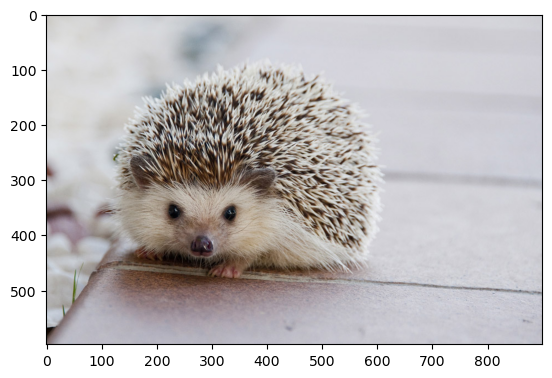

PyObject <matplotlib.image.AxesImage object at 0x7f75a7f7be50>

In [2]:
# 画像読み込み
image_file_path = "./data/gahag-0059907781-1.jpg"
img = Image.open(image_file_path)

# 元の画像の表示
Image.show(img)

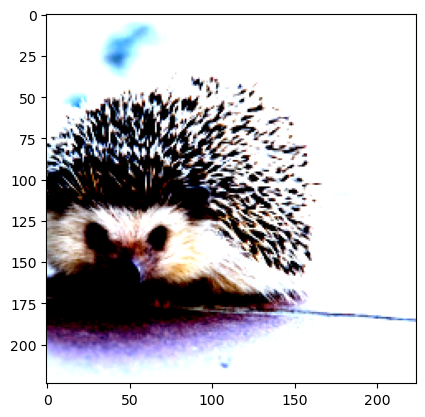

PyObject <matplotlib.image.AxesImage object at 0x7f75a7cbcb50>

In [3]:
# 画像をVGG16に読み込ませられるように処理する
transform = make_transformer_for_vgg16()
img_transformed = transform(img)

# 変換後の画像を表示
## matplotlibでプロットできる画像の形式: (高さ, 幅, 色数)
## -> (色数, 高さ, 幅)の配列を(高さ, 幅, 色数)に変換して表示
### permutedims(対象配列, 次元の順番配列): 転置行列の生成関数
Image.show(permutedims(img_transformed, [2, 3, 1]))

## 出力結果からラベルを予測する後処理の実装

VGG-16モデルで画像認識を実行すると `torch.Size([1, 1000])` という1000次元テンソルが出力される

これは、ILSVRCで使われる1000個のラベルそれぞれに合致する確率を予測したものとなっている

そのため、これを1000個のラベル名と対応させ、実際に「何の画像である確率が高いのか」を結果として出力する変換する必要がある

### 実装
- ILSVRCで使われる1000個のラベル名は、`imagenet_class_index.json`から読み込む
- VGG-16が出力した1000次元のPyTorchテンソルを `Array{Float32, 1}(1000-elements)`型に変換する
- `Array{Float32, 1}`型の予測データのうち、値が最大であるもの（一致確率が最も高いもの）のインデックスを得る
- 上記インデックスと対応するラベル名を`imagenet_class_index.json`から取得する

In [6]:
# JSONデータを扱えるようにする
using PyCall
const json = pyimport("json")

# ILSVRCのラベル情報をロードする
ILSVRC_class_index = json.load(open("./data/imagenet_class_index.json", "r"))

Dict{Any,Any} with 1000 entries:
  "1"   => ["n01443537", "goldfish"]
  "519" => ["n03127925", "crate"]
  "788" => ["n04200800", "shoe_shop"]
  "774" => ["n04133789", "sandal"]
  "599" => ["n03530642", "honeycomb"]
  "491" => ["n03000684", "chain_saw"]
  "228" => ["n02105505", "komondor"]
  "332" => ["n02328150", "Angora"]
  "190" => ["n02095889", "Sealyham_terrier"]
  "227" => ["n02105412", "kelpie"]
  "980" => ["n09472597", "volcano"]
  "297" => ["n02134418", "sloth_bear"]
  "605" => ["n03584254", "iPod"]
  "24"  => ["n01622779", "great_grey_owl"]
  "928" => ["n07614500", "ice_cream"]
  "204" => ["n02098413", "Lhasa"]
  "416" => ["n02777292", "balance_beam"]
  "23"  => ["n01616318", "vulture"]
  "160" => ["n02088094", "Afghan_hound"]
  "561" => ["n03384352", "forklift"]
  "859" => ["n04442312", "toaster"]
  "891" => ["n04542943", "waffle_iron"]
  "815" => ["n04275548", "spider_web"]
  "981" => ["n09835506", "ballplayer"]
  "253" => ["n02110806", "basenji"]
  ⋮     => ⋮

In [10]:
# 一致確率が最も高いラベル名を取得する関数
## out: VGG-16の予測結果をArray型に変換したもの
## class_index: インデックスとラベル名の対応表（ILSVRC_class_index）
predict_label(out::Array{Float32, 1}, class_index::Dict{Any, Any})::String = begin
    # findall関数は条件にマッチする配列のインデックスを全て返す
    ## `.`演算子は配列に対して関数を適用する
    ## .== で配列の各要素が右値と等しいか判定できる
    maxindex = findall(out .== maximum(out))[1]
    # Juliaのインデックスは1から始まるため、対応させる際は-1する
    class_index[string(maxindex-1)][2] # Any[:1, :2] の2番目がラベル名
end

predict_label (generic function with 2 methods)

In [8]:
# 前処理した画像データをVGG-16モデルに渡し、予測させる
## 予測結果を1000要素を持つ1次元配列（ベクトル）に変換
out = vec(predict(net, [img_transformed]))

1000-element Array{Float32,1}:
 -0.30564338
  0.36970988
 -2.112612
 -2.6410174
 -2.2402394
 -1.5040367
 -1.0501657
  2.1899736
  2.381485
  4.9082355
  2.184169
  4.957275
  2.5677147
  ⋮
  1.6868336
  0.55241084
  5.2849345
  0.6305899
 -0.0553883
 -3.776128
 -2.6014624
  2.4884188
  1.1431268
 -2.106125
  4.101773
 -1.1379858

In [11]:
# 予測結果を最も一致確率の高いラベル名に変換する
result = predict_label(out, ILSVRC_class_index)

# 結果表示
println("入力画像の予測結果: $(result)")

入力画像の予測結果: porcupine


## 結果

予測結果は porcupine (ヤマアラシ) だった

惜しい！

と言いたいところだが、実はILSVRCのラベルとしてハリネズミ（hedgehog）はそもそも用意されていない（ハリネズミとヤマアラシを同一の動物としてモデリングしている）

ということで、正解ラベルとして用意されている中で最も近いものを予測することに成功したということができるだろう